In [136]:
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


In [137]:
# importing data
# numpy array with columns of date/time and num_value

PC_0192_details = pd.read_csv("Details_PC-0192.csv", sep=',')
# dtype='str', comments="#", delimiter="\t", unpack=False)
PC_0192_details

,Project ID,birth_deid_date,death_deid_date,sex,icu_visit,icu_start_deid_dttm,icu_end_deid_dttm,failed_extubation_flag,failed_extubation_deid_date,intubation_flag,extubation_flag,extubation_deid_date,extubation_score,re_intubation_deid_date,icu_ward
0,PC0192,22/06/2004,NaN,Male,1,22/12/2016 11:53,18/02/2017 17:13,1,10/01/2017 18:00,1,1,28/12/2016 18:00,5,11/01/2017 14:00,FLAMI


In [138]:
# changing required fields to correct datetime data type to avoid string issues

PC_0192_details['failed_extubation_deid_date'] = pd.to_datetime(PC_0192_details['failed_extubation_deid_date'], format='%d/%m/%Y %H:%M')
PC_0192_details['re_intubation_deid_date'] = pd.to_datetime(PC_0192_details['re_intubation_deid_date'], format='%d/%m/%Y %H:%M')

In [139]:
PC_0192_details

,Project ID,birth_deid_date,death_deid_date,sex,icu_visit,icu_start_deid_dttm,icu_end_deid_dttm,failed_extubation_flag,failed_extubation_deid_date,intubation_flag,extubation_flag,extubation_deid_date,extubation_score,re_intubation_deid_date,icu_ward
0,PC0192,22/06/2004,NaN,Male,1,22/12/2016 11:53,18/02/2017 17:13,1,2017-01-10 18:00:00,1,1,28/12/2016 18:00,5,2017-01-11 14:00:00,FLAMI


In [140]:
failed_extubation = PC_0192_details.iloc[0,8]
re_intubation = PC_0192_details.iloc[0,13]

print(failed_extubation, re_intubation)

2017-01-10 18:00:00 2017-01-11 14:00:00


In [141]:
# creating df for the time series data

PC_0192_data = pd.read_csv("PC0192_1_HR.csv", sep=',')
PC_0192_data

,monitor,record_date_time,num_value
0,HR,2016-12-22 12:09:21,98
1,HR,2016-12-22 12:09:26,98
2,HR,2016-12-22 12:09:31,98
3,HR,2016-12-22 12:09:36,96
4,HR,2016-12-22 12:09:41,97
...,...,...,...
942176,HR,2017-02-18 17:08:34,96
942177,HR,2017-02-18 17:08:39,96
942178,HR,2017-02-18 17:08:44,95
942179,HR,2017-02-18 17:08:49,96


In [142]:
# making sure 'record_date_time' is of the correct type

# PC_0192_data['record_date_time'] = PC_0192_data['record_date_time'].dt.strftime('%d/%m/%Y %H:%M:%S')
PC_0192_data['record_date_time'] = pd.to_datetime(PC_0192_data['record_date_time'], format='%Y-%m-%d %H:%M:%S')
PC_0192_data

,monitor,record_date_time,num_value
0,HR,2016-12-22 12:09:21,98
1,HR,2016-12-22 12:09:26,98
2,HR,2016-12-22 12:09:31,98
3,HR,2016-12-22 12:09:36,96
4,HR,2016-12-22 12:09:41,97
...,...,...,...
942176,HR,2017-02-18 17:08:34,96
942177,HR,2017-02-18 17:08:39,96
942178,HR,2017-02-18 17:08:44,95
942179,HR,2017-02-18 17:08:49,96


In [143]:
# 'failed_extubation' and 're_intubation' are formatted differently to 'PC_0192_data'
# change manually for now, BUT COME BACK TO THIS AND CHANGE PROPERLY

# failed_extubation_2 = '2017-01-10 18:00:00'
# re_intubation_2 = '2017-01-11 14:00:00'

# fixed this

In [144]:
# PC_0192_data.timestamp.searchsorted(failed_extubation)

In [145]:
# dt='2022-02-07T23:18:06.08349'
# PC_0192_data. timestamp.searchsorted(dt)

In [146]:
# np.where(PC_0192_data["record_date_time"] == test)[0]

In [148]:
# failed_extubation = pd.to_datetime(failed_extubation)
# s = PC_0192_data['record_date_time'].loc[PC_0192_data['record_date_time'].index.unique()[PC_0192_data['record_date_time'].index.unique().get_loc(failed_extubation, method='nearest')]]

In [149]:
# finding indexes at which failed_extubation and re_intubation would need to be inserted to maintain order

failed_extubation_index = PC_0192_data.record_date_time.searchsorted(failed_extubation)
re_intubation_index = PC_0192_data.record_date_time.searchsorted(re_intubation)

print(failed_extubation_index, re_intubation_index)

320515 334633


In [150]:
# lifting data for the time peried where patient was extubated

PC_0192_extubated = PC_0192_data.iloc[failed_extubation_index+1:re_intubation_index-1, :]
PC_0192_extubated

,monitor,record_date_time,num_value
320516,HR,2017-01-10 18:00:06,100
320517,HR,2017-01-10 18:00:11,100
320518,HR,2017-01-10 18:00:16,100
320519,HR,2017-01-10 18:00:21,100
320520,HR,2017-01-10 18:00:26,99
...,...,...,...
334627,HR,2017-01-11 13:59:32,121
334628,HR,2017-01-11 13:59:36,121
334629,HR,2017-01-11 13:59:42,121
334630,HR,2017-01-11 13:59:46,121


<AxesSubplot:xlabel='record_date_time'>

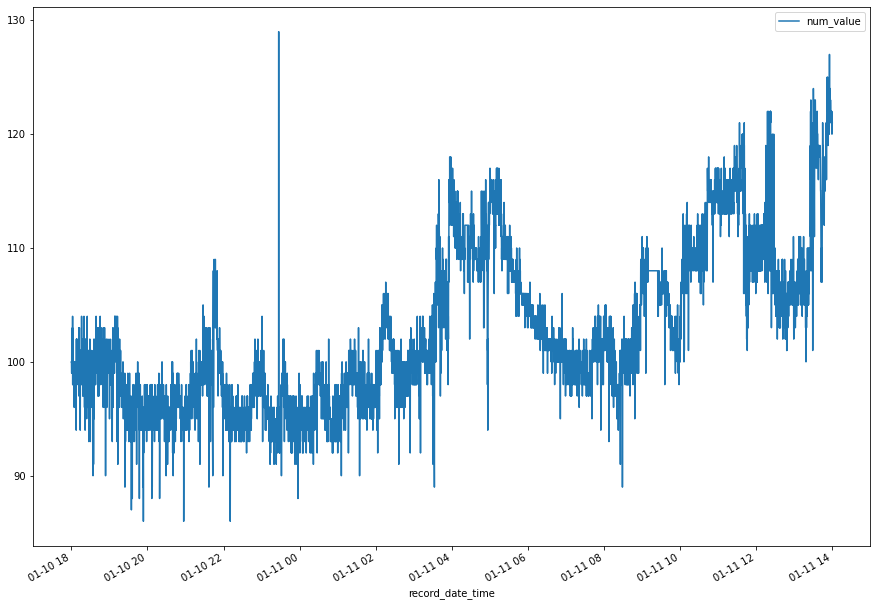

In [151]:
PC_0192_extubated.plot('record_date_time', 'num_value', figsize=(15, 11))

In [152]:
# use timedelta to add a period of time to a timestamp:

PC_0192_extubated['record_date_time'].iloc[0] + timedelta(minutes=10)
PC_0192_extubated['record_date_time'].iloc[-1]

Timestamp('2017-01-11 13:59:52')

### Rolling mean:

In [153]:
# following has incorrect timestamps

# k = 0

# PC_0192_mean = pd.DataFrame(columns=['start_time','end_time','mean'])

# while (PC_0192_extubated['record_date_time'].iloc[0] + timedelta(minutes=10+k)) < PC_0192_extubated['record_date_time'].iloc[-1]:

#     index_1 = PC_0192_extubated.record_date_time.searchsorted(PC_0192_extubated['record_date_time'].iloc[0] + timedelta(minutes=k))
#     index_2 = PC_0192_extubated.record_date_time.searchsorted(PC_0192_extubated['record_date_time'].iloc[0] + timedelta(minutes=10+k))

#     mean = PC_0192_extubated['num_value'][index_1:index_2].mean(axis=0)

#     PC_0192_mean = PC_0192_mean.append({'start_time': PC_0192_extubated['record_date_time'].iloc[0] + timedelta(minutes=k),
#     'end_time':PC_0192_extubated['record_date_time'].iloc[0] + timedelta(minutes=10+k), 'mean':mean}, ignore_index=True)
#     k += 1


In [191]:
k = 0

PC_0192_mean = pd.DataFrame(columns=['start_time','end_time','mean'])

while (PC_0192_extubated['record_date_time'].iloc[0] + timedelta(minutes=10+k)) < PC_0192_extubated['record_date_time'].iloc[-1]:

    index_1 = PC_0192_extubated.record_date_time.searchsorted(PC_0192_extubated['record_date_time'].iloc[0] + timedelta(minutes=k))
    index_2 = PC_0192_extubated.record_date_time.searchsorted(PC_0192_extubated['record_date_time'].iloc[0] + timedelta(minutes=10+k))

    mean = PC_0192_extubated['num_value'][index_1:index_2].mean(axis=0)

    PC_0192_mean = PC_0192_mean.append({'start_time': PC_0192_extubated['record_date_time'].iloc[index_1], 'end_time':PC_0192_extubated['record_date_time'].iloc[index_2], 'mean':mean}, ignore_index=True)
    k += 1

In [192]:
PC_0192_extubated['record_date_time'].iloc[index_1]

Timestamp('2017-01-11 13:49:07')

In [193]:
PC_0192_mean

,start_time,end_time,mean
0,2017-01-10 18:00:06,2017-01-10 18:10:06,99.521008
1,2017-01-10 18:01:06,2017-01-10 18:11:06,99.487395
2,2017-01-10 18:02:11,2017-01-10 18:12:06,99.344538
3,2017-01-10 18:03:06,2017-01-10 18:13:06,99.383333
4,2017-01-10 18:04:06,2017-01-10 18:14:06,99.4
...,...,...,...
1185,2017-01-11 13:45:07,2017-01-11 13:55:07,119.408333
1186,2017-01-11 13:46:07,2017-01-11 13:56:06,119.916667
1187,2017-01-11 13:47:07,2017-01-11 13:57:06,120.483333
1188,2017-01-11 13:48:07,2017-01-11 13:58:07,121.075


In [194]:
# PC_0192_mean.plot(x='start_time', y='mean')

# TypeError: no numeric data to plot

In [195]:
index_1 = PC_0192_extubated.record_date_time.searchsorted(PC_0192_extubated['record_date_time'].iloc[0] + timedelta(minutes=k))
index_2 = PC_0192_extubated.record_date_time.searchsorted(PC_0192_extubated['record_date_time'].iloc[0] + timedelta(minutes=10+k))

mean = PC_0192_extubated['num_value'][index_1:index_2].mean()
mean

121.98305084745763

In [196]:
PC_0192_mean.dtypes

start_time    datetime64[ns]
end_time      datetime64[ns]
mean                  object
dtype: object

In [197]:
# PC_0192_mean['mean'] = pd.to_numeric(PC_0192_mean['mean'])

# TypeError: Invalid object type at position 910

In [198]:
PC_0192_mean.iloc[910]

start_time    2017-01-11 09:24:32
end_time      2017-01-11 09:24:32
mean                          NaT
Name: 910, dtype: object

In [199]:
# PC_0192_mean = PC_0192_mean.drop(910)

In [200]:
# PC_0192_mean.plot(x='start_time', y='mean')

In [201]:
# PC_0192_mean['mean'] = pd.to_numeric(PC_0192_mean['mean'])

# TypeError: Invalid object type at position 910

In [202]:
# systematically removing NaT rows

for i, row in enumerate(PC_0192_mean['mean']):
    if pd.isnull(row):
        PC_0192_mean = PC_0192_mean.drop(i)

In [203]:
# PC_0192_mean['mean'] = pd.to_numeric(PC_0192_mean['mean'])

# TypeError: Invalid object type at position 910

<AxesSubplot:xlabel='start_time'>

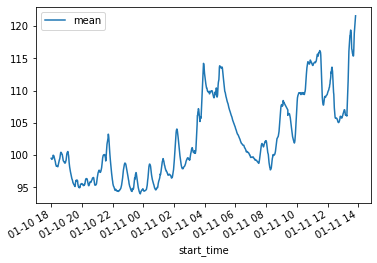

In [204]:
PC_0192_mean['mean'] = pd.to_numeric(PC_0192_mean['mean'])

PC_0192_mean.plot(x='start_time', y='mean')

### Rolling variance:

In [205]:
k = 0

PC_0192_var = pd.DataFrame(columns=['start_time','end_time','variance'])

while (PC_0192_extubated['record_date_time'].iloc[0] + timedelta(minutes=10+k)) < PC_0192_extubated['record_date_time'].iloc[-1]:

    index_1 = PC_0192_extubated.record_date_time.searchsorted(PC_0192_extubated['record_date_time'].iloc[0] + timedelta(minutes=k))
    index_2 = PC_0192_extubated.record_date_time.searchsorted(PC_0192_extubated['record_date_time'].iloc[0] + timedelta(minutes=10+k))

    var = PC_0192_extubated['num_value'][index_1:index_2].var(axis=0)

    PC_0192_var = PC_0192_var.append({'start_time': PC_0192_extubated['record_date_time'].iloc[index_1], 'end_time':PC_0192_extubated['record_date_time'].iloc[index_2], 'variance':var}, ignore_index=True)
    k += 1


In [206]:
PC_0192_var

,start_time,end_time,variance
0,2017-01-10 18:00:06,2017-01-10 18:10:06,1.963538
1,2017-01-10 18:01:06,2017-01-10 18:11:06,1.963823
2,2017-01-10 18:02:11,2017-01-10 18:12:06,1.685372
3,2017-01-10 18:03:06,2017-01-10 18:13:06,1.683754
4,2017-01-10 18:04:06,2017-01-10 18:14:06,1.939496
...,...,...,...
1185,2017-01-11 13:45:07,2017-01-11 13:55:07,9.520938
1186,2017-01-11 13:46:07,2017-01-11 13:56:06,10.497199
1187,2017-01-11 13:47:07,2017-01-11 13:57:06,10.503922
1188,2017-01-11 13:48:07,2017-01-11 13:58:07,8.053151


In [207]:
# systematically removing NaT rows

for i, row in enumerate(PC_0192_var['variance']):
    if pd.isnull(row):
        PC_0192_var = PC_0192_var.drop(i)

<AxesSubplot:xlabel='start_time'>

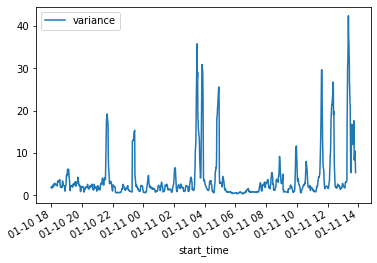

In [209]:
PC_0192_var['variance'] = pd.to_numeric(PC_0192_var['variance'])

PC_0192_var.plot(x='start_time', y='variance')